# Studying location of condensation points

In [1]:
from gnn_tracking_hpo.util.paths import add_scripts_path

import matplotlib.pyplot as plt
import copy
import numpy as np
from gnn_tracking.graph_construction.graph_builder import load_graphs
from torch_geometric.loader import DataLoader
import torch
from tqdm import tqdm
add_scripts_path()

In [2]:
from tune_fixed_ec import PretrainedECTrainable

## Load model

In [3]:
trainable = PretrainedECTrainable.reinstate("fixed-ec-51f87ec0", "af5b5461", epoch=-1, n_graphs=0)

[15:21:49 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/fixed-ec-51f87ec0/PretrainedECTrainable_af5b5461_4_attr_pt_thld=0.6079,batch_size=5,ec_epoch=32,ec_hash=51f87ec0,ec_project=ec,ec_pt_thld=0.0000,gnn_2023-02-01_10-37-15/params.json
[15:21:49 gnnt_hpo] INFO: Initializing pre-trained EC
[15:21:49 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/ec/ECTrainable_51f87ec0_1_batch_size=5,ec_pt_thld=0.7711,focal_alpha=0.3824,focal_gamma=2.5581,gnn_tracking_experiments_hash=f2480a9a_2023-01-30_23-14-13/params.json
[15:21:49 gnnt_hpo] INFO: I'm running on a node with job ID=45779319
[15:21:49 gnnt_hpo] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[15:21:49 gnnt_hpo] INFO: The ID of my dispatcher is 0
[15:21:49 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[15:21:49 gnnt_hpo] DEBUG: Got config
┌──────────────────────────────────────┬───────────────────────

## Load data

In [4]:
graphs = load_graphs("/scratch/gpfs/kl5675/data/gnn_tracking/graphs/training_part09", stop=10, n_processes=6)

[15:21:51] INFO: Loading 10 graphs (out of 3200 available).
[15:21:51] DEBUG: First graph is data29004_s0.pt, last graph is data29004_s17.pt


In [5]:
loader = DataLoader(graphs, num_workers=6)

In [6]:
trainer = trainable.trainer
trainer.model.eval()

study_input = []

interesting_keys = ["beta", "particle_id", "ec_hit_mask"]

stop = None
with torch.no_grad():
    for idx, data in tqdm(enumerate(loader), total=len(graphs)):
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        study_input.append(
            {key: model_output[key].cpu().numpy() for key in interesting_keys}
        )
        study_input[-1]["x"] = data.x.cpu().numpy()
        if idx == stop:
            break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


In [7]:
masked_study_input = copy.deepcopy(study_input)
for key in ["particle_id", "x"]:
    for item in masked_study_input:
        item[key] = item[key][item["ec_hit_mask"]]
for item in masked_study_input:
    item["r"] = item["x"][:, 0]
    item["z"] = item["x"][:, 2]

## Looking at individual PIDs

In [8]:
fc = masked_study_input[0]

Text(0.5, 1.0, 'Position of CP for random PIDs')

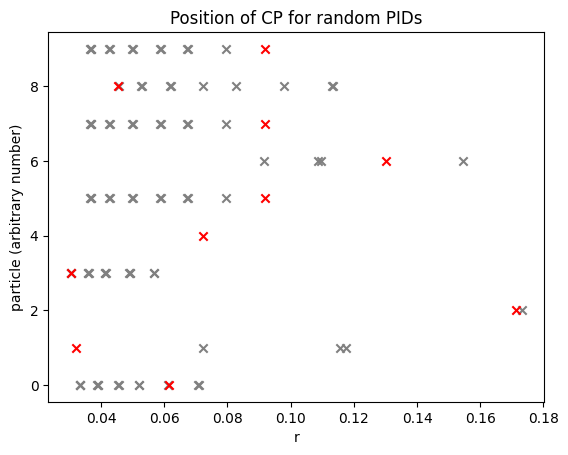

In [9]:
fig, ax = plt.subplots()
selected_pids = np.random.choice(fc["particle_id"], 10)
for ipid, pid in enumerate(selected_pids):
    mask = fc["particle_id"] == pid
    xs = fc["r"][mask]
    ys = np.array([ipid] * mask.sum())
    condensation_beta = np.max(fc["beta"][mask])
    is_condensation_mask = fc["beta"][mask] == condensation_beta
    ax.scatter(xs[~is_condensation_mask], ys[~is_condensation_mask], marker="x", color="gray")
    ax.scatter(xs[is_condensation_mask], ys[is_condensation_mask], marker="x", color="red")
ax.set_xlabel("r")
ax.set_ylabel("particle (arbitrary number)")
ax.set_title("Position of CP for random PIDs")

## Plot position of condensation point in normalized r distribution

In [10]:
def normalize_r(r: np.ndarray) -> np.ndarray:
    normalized_r = (r - r.min()) / (r.max() - r.min())
    assert np.allclose(normalized_r.min(), 0.0)
    assert np.allclose(normalized_r.max(), 1.0)
    return normalized_r

In [11]:
def get_cp_r_position(inpt, selection=None) -> np.ndarray:
    vals = []
    for graph in inpt:
        for pid in np.unique(graph["particle_id"]):
            if pid <= 0:
                continue
            mask = graph["particle_id"] == pid
            if mask.sum() < 3:
                continue
            beta = graph["beta"][mask]
            cp_index = np.argmax(beta)
            r = graph["r"][mask]
            z = graph["z"][mask]

            barrel_hits = np.abs(z) < (450 / 1000)
            barrel_frac = barrel_hits.sum() / len(barrel_hits)
            if not selection:
                pass
            elif selection == "barrel":
                if not (barrel_frac > 0.5):
                    continue
            elif selection == "not_barrel":
                if not (barrel_frac < 0.5):
                    continue
            else:
                raise ValueError(f"Unknown selection {selection}")

            # Map rs between 0 and 1
            r_normalized = normalize_r(r)
            vals.append(r_normalized[cp_index])
    vals = np.array(vals)
    return vals

In [12]:
def plot_r_positions(vals):
    fig, ax = plt.subplots()
    ax.hist(vals, bins=40)
    ax.set_xlabel("$r$ of CP when normalizing $r$ to $[0, 1]$ (separately for each particle)")
    ax.set_ylabel("count")
    return ax

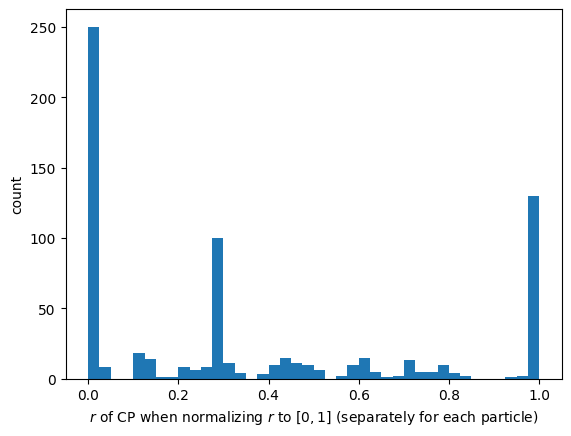

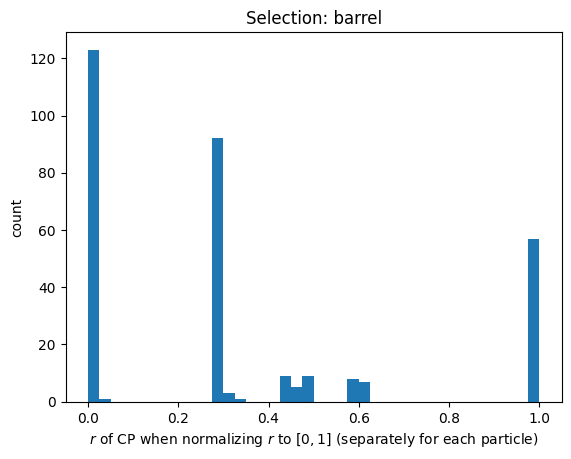

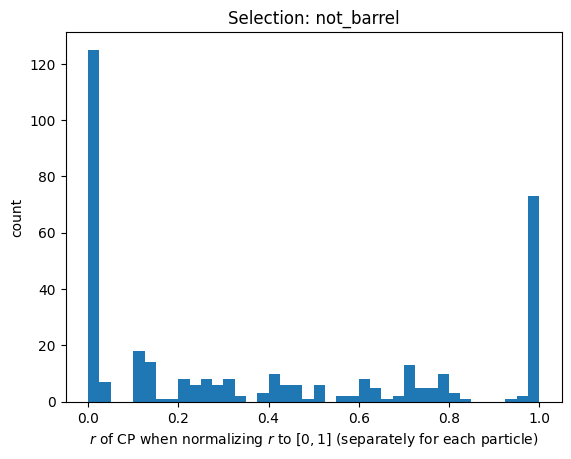

In [13]:
for sel in [None, "barrel", "not_barrel"]:
    ax = plot_r_positions(get_cp_r_position(masked_study_input, selection=sel))
    if sel:
        ax.set_title(f"Selection: {sel}")

In [14]:
def barrel_frac_vs_r_position(inpt):
    bfs = []
    rps = []
    for graph in inpt:
        for pid in np.unique(graph["particle_id"]):
            if pid <= 0:
                continue
            mask = graph["particle_id"] == pid
            if mask.sum() < 3:
                continue
            beta = graph["beta"][mask]
            cp_index = np.argmax(beta)
            r = graph["r"][mask]
            z = graph["z"][mask]

            barrel_hits = np.abs(z) < (450 / 1000)
            barrel_frac = barrel_hits.sum() / len(barrel_hits)
            bfs.append(barrel_frac)
            r_normalized = normalize_r(r)
            rps.append(r_normalized[cp_index])
    return np.array(bfs), np.array(rps)

Text(0, 0.5, 'r position of CP')

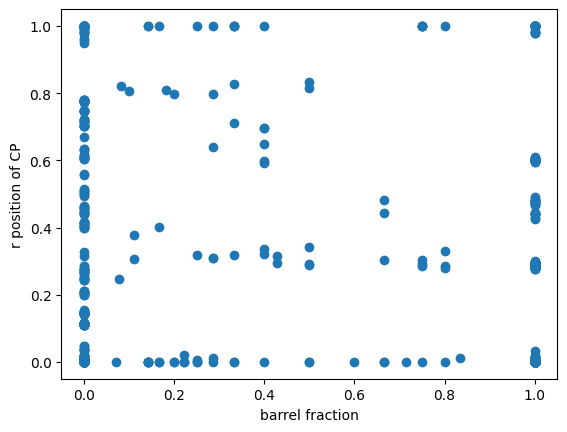

In [15]:
bfs, rps = barrel_frac_vs_r_position(masked_study_input)
fig, ax = plt.subplots()
ax.scatter(bfs, rps)
ax.set_xlabel("barrel fraction")
ax.set_ylabel("r position of CP")

In [17]:
other_zs = []
other_rs = []
zs = []
rs = []
pids = []
for graph in masked_study_input:
    for pid in np.unique(graph["particle_id"]):
        if pid <= 0:
            continue
        mask = graph["particle_id"] == pid
        if mask.sum() < 3:
            continue
        beta = graph["beta"][mask]
        cp_index = np.argmax(beta)
        not_cp = np.arange(len(beta)) != cp_index
        r = graph["r"][mask]
        r_normalized = normalize_r(r)

        if not 0.25 < r_normalized[cp_index] < 0.35:
            # print("skipping", pid)
            continue

        z = graph["z"][mask]
        pids.append(pid)
        rs.append(r[cp_index])
        zs.append(z[cp_index])
        other_rs.append(r[not_cp])
        other_zs.append(z[not_cp])

In [18]:
def unison_shuffled_copies(*arrays):
    size = int(min(len(a) for a in arrays))
    p = np.random.permutation(size)
    # not everything can be/is a numpy array
    ret = []
    for array in arrays:
        ret.append(
            [array[i] for i in p]
        )
    return ret

Text(0, 0.5, 'r')

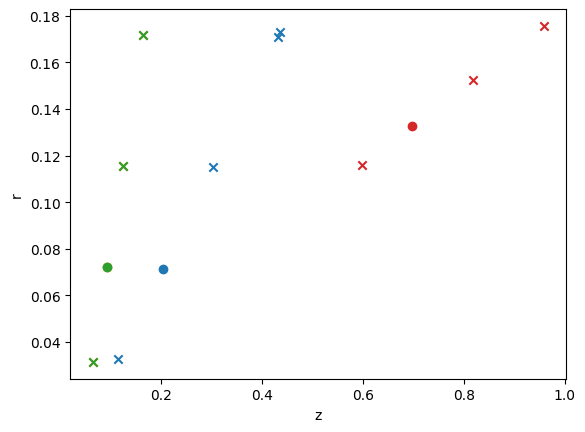

In [19]:
fig, ax = plt.subplots()
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, (pid, r, z, _other_rs, _other_zs) in enumerate(list(zip(*unison_shuffled_copies(pids, rs, zs, other_rs, other_zs)))[:4]):
    color = colors[i]
    ax.scatter(z, r, marker="o", color=color, label=pid)
    ax.scatter(_other_zs, _other_rs,  marker="x", color=color)
# ax.legend()
ax.set_xlabel("z")
ax.set_ylabel("r")